In [31]:
import pyart
import sys
from tkinter import *
from tkinter import filedialog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import math
import warnings
warnings.filterwarnings('ignore')

In [32]:
plt.rcParams['axes.facecolor'] = '#0e1111'
plt.rcParams['figure.facecolor'] = '#232b2b'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

In [33]:
lon_limits = []
lat_limits = []

def set_map_extent(extent):
    dtor = math.pi/180.0
    max_range = extent
    maxrange_meters = max_range * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

    for azi in range(0,360,90):
        azimuth = 90. - azi
        dazimuth = azimuth * dtor
        lon_maxrange = radar_lon + math.cos(dazimuth) * meters_to_lon * maxrange_meters
        lat_maxrange = radar_lat + math.sin(dazimuth) * meters_to_lat * maxrange_meters
        lon_limits.append(lon_maxrange)
        lat_limits.append(lat_maxrange)

dict_keys(['velocity', 'reflectivity', 'spectrum_width'])


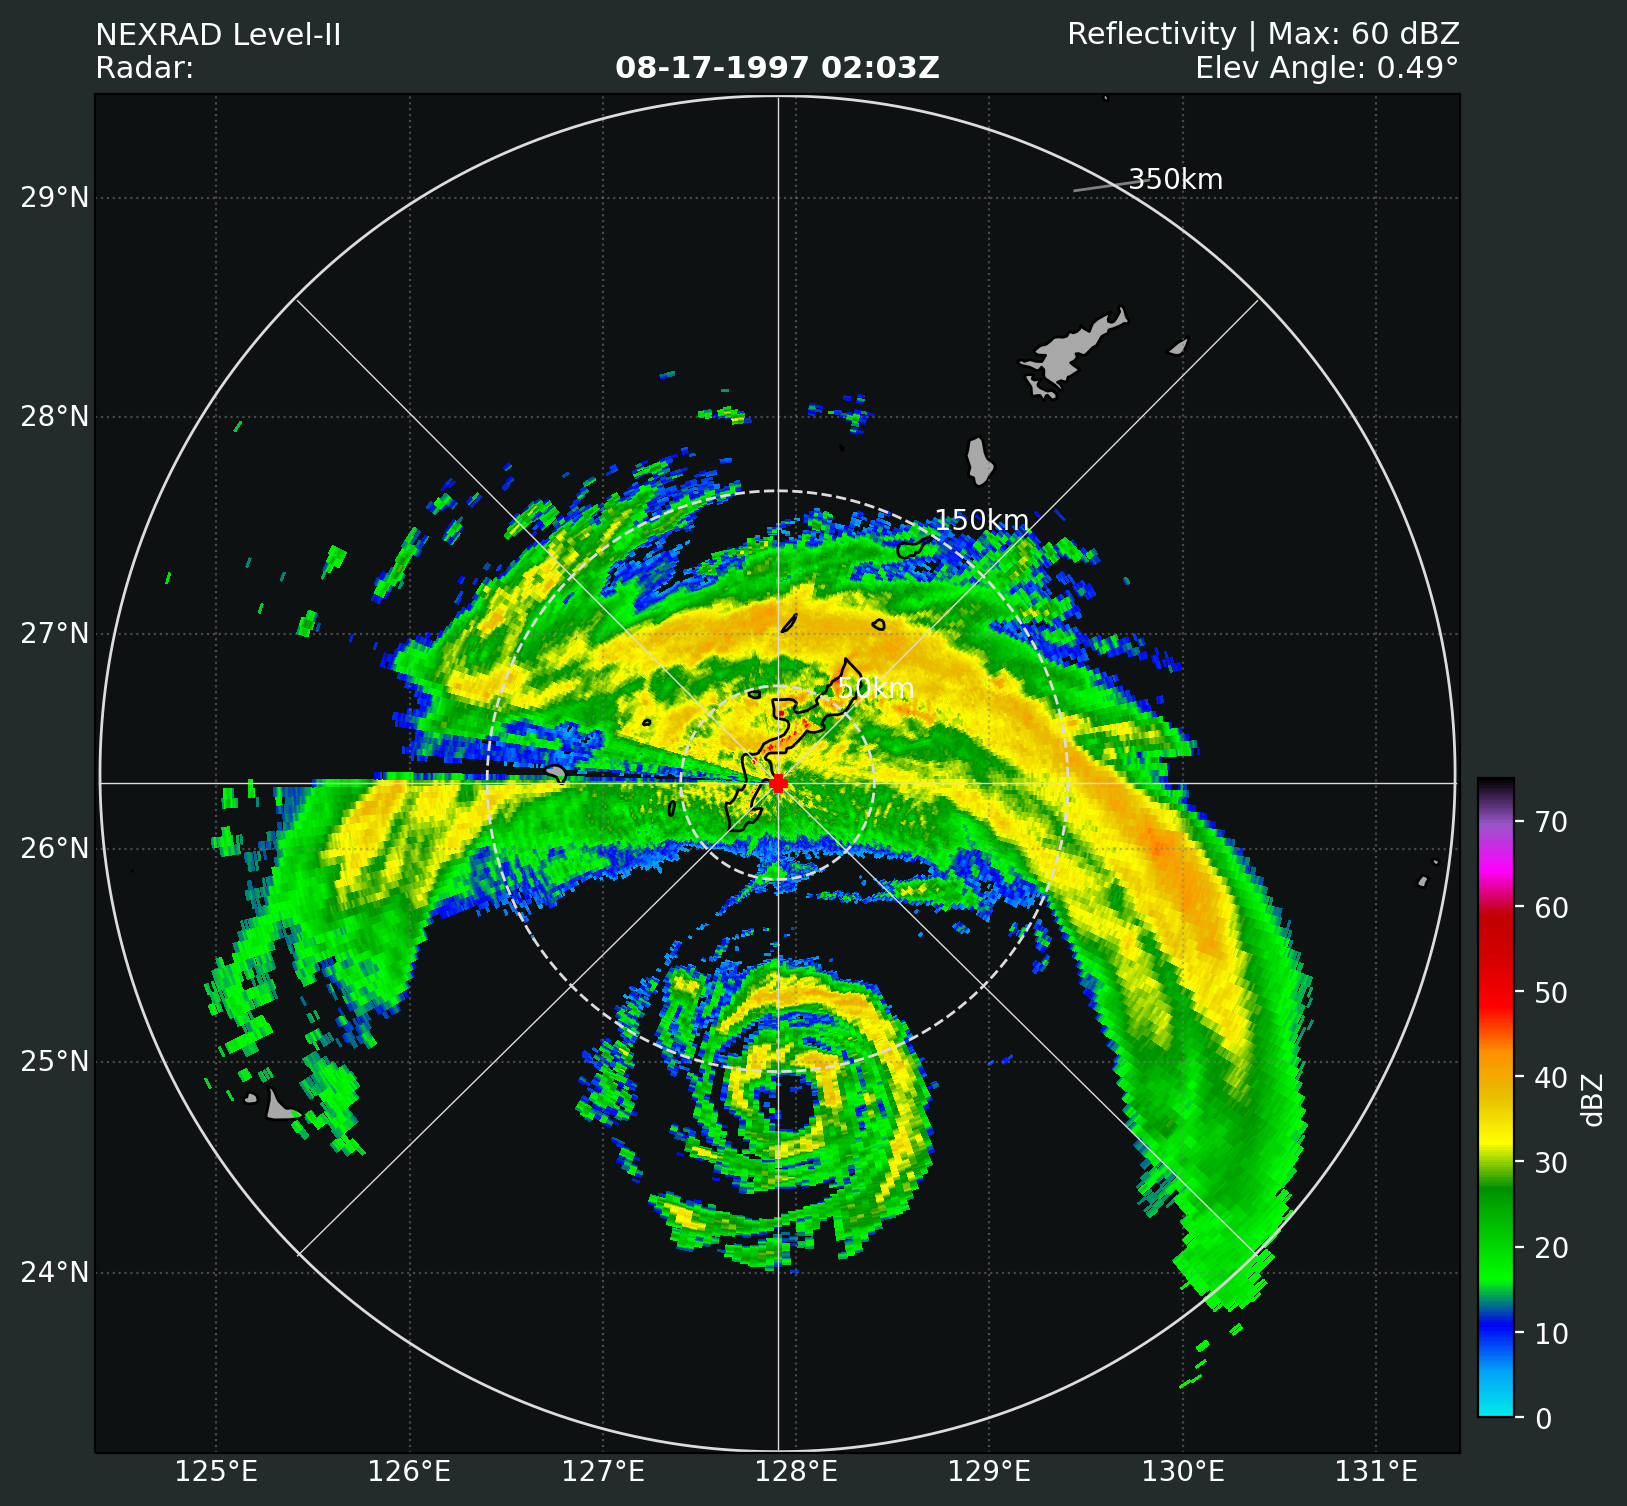

In [34]:
root = Tk()
root.title('File viewer')

root.filename = filedialog.askopenfilenames(initialdir="D:/TY Winnie 1997 NEXRAD", title="Choose file(s)", filetypes=[("all files", "*.*")])

if (len(root.filename) == 0):
    print ("No file selected.")
    exit
    root.destroy()
else:
    for file in root.filename:
        radar = pyart.io.read_nexrad_archive(file)
        
        #radar_lat = radar.latitude['data'][0]
        #radar_lon = radar.longitude['data'][0]
        radar_lat = radar.latitude['data'] = np.array([26.30780029296875])
        radar_lon = radar.longitude['data'] = np.array([127.90347290039062])
        radar_name = radar.metadata['instrument_name']

        fields = radar.fields.keys()
        print(fields)
        #radar.info()
        
        set_map_extent(352)
        maxr = (50, 150, 350)
        
        display = pyart.graph.RadarMapDisplay(radar)
        
        projection = ccrs.Mercator() #central_longitude=radar_lon
        fig = plt.figure(figsize=(9,9), dpi=200)
        ax = plt.axes(projection=projection)

        gl = ax.gridlines(draw_labels=True, color='gray', linewidth=0.8, alpha=0.5, linestyle=':')
        gl.top_labels = gl.right_labels = False

        resol = '10m'
        land = cfeature.NaturalEarthFeature('physical', 'land', scale=resol, facecolor=cfeature.COLORS['land'])
        ax.add_feature(land, facecolor='#A8A8A8', zorder=0)
                
        sweep = 0
        
        # Make a nice time stamp
        index_at_start = radar.sweep_start_ray_index['data'][sweep]
        time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
        formatted_date = time_at_start_of_radar.strftime('%m-%d-%Y %H:%MZ')
        
        # Remove reflectivity values below a threshold
        gatefilter = pyart.filters.GateFilter(radar)
        gatefilter.exclude_below('reflectivity', 5)
                
        display.plot_ppi_map('reflectivity', sweep=sweep, vmin=0, vmax=75,
                         min_lon=lon_limits[1], max_lon=lon_limits[3], min_lat=lat_limits[0], max_lat=lat_limits[2],
                         lon_lines=np.arange(lon_limits[1], lon_limits[3], 1), lat_lines=np.arange(lat_limits[0], lat_limits[2], 1),
                         resolution=resol, fig=fig, projection=projection, cmap='pyart_NWSRef', colorbar_flag=False,
                         gatefilter=gatefilter, title_flag=False, lat_0=radar_lat, lon_0=radar_lon)
        
        # Return the max reflectivity in sweep
        slice_indices = radar.get_slice(sweep)
        max_ref = round(radar.fields['reflectivity']['data'][slice_indices].max()) # Get max reflectivity and round off

        elev_angle = (round(radar.elevation['data'][slice_indices].mean(), 2)) # Round off elevation angle to 2 decimal places

        # Resize colorbar
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0+0.02, 0.02, ax.get_position().height-0.4])
        display.plot_colorbar(mappable=None, field=None, label='dBZ', orient='vertical', cax=cax, ax=None, fig=None, ticks=None, ticklabs=None)
        cax.yaxis.label.set_color('white')
        
        deg_sign = u'\N{DEGREE SIGN}'

        ax.set_title('NEXRAD Level-II\nRadar: ' + radar_name, fontsize=11, loc='left')
        ax.set_title(str(formatted_date), fontsize=11, loc='center', fontweight='bold')
        ax.set_title('Reflectivity | Max: ' + str(max_ref) + ' dBZ' + '\nElev Angle: ' + str(elev_angle) + deg_sign, fontsize=11, loc='right')

        # Plot range rings at 50, 100, 350km
        display.plot_range_ring(50., line_style='--', color='gainsboro', lw=1)
        display.plot_range_ring(150., line_style='--', color='gainsboro', lw=1)
        display.plot_range_ring(350., line_style='-', color='gainsboro', lw=1)
    
        # Create azimuth lines
        dtor = math.pi/180.0
        max_range = 350
        maxrange_meters = max_range * 1000.
        meters_to_lat = 1. / 111177.
        meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

        for azi in range(0,360,45): # 45 degree intervals
            azimuth = 90. - azi
            dazimuth = azimuth * dtor
            lon_maxrange = radar_lon + math.cos(dazimuth) * meters_to_lon * maxrange_meters
            lat_maxrange = radar_lat + math.sin(dazimuth) * meters_to_lat * maxrange_meters
            display.plot_line_geo([radar_lon, lon_maxrange], [radar_lat, lat_maxrange], line_style='-', lw=0.5, color='gainsboro')
        
        # Show range ring values
        azim = 90. - 30
        dazim = azim * dtor
        for i in maxr:
            maxr_m = i * 1000.
            lon_maxr = radar_lon + math.cos(dazim) * meters_to_lon * maxr_m
            lat_maxr = radar_lat + math.sin(dazim) * meters_to_lat * maxr_m
            display.plot_point(lon_maxr, lat_maxr, symbol='None', label_text=' '+str(i)+'km')
       
        # Indicate radar location with a point
        display.plot_point(radar_lon, radar_lat, symbol='rP')

In [35]:
root.destroy()

root.mainloop()